In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = dsets.CIFAR10(root='./data', 
                           train=True,
                           download=True, 
                           transform=transform)

test_data  = dsets.CIFAR10(root='./data', 
                           train=False,
                           download=True, 
                           transform=transform)


0.0%

100.0%

Files already downloaded and verified


In [4]:
batch_size = 125

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

test_loader = DataLoader(test_data, 
                         batch_size=5,
                         shuffle=False,
                         num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

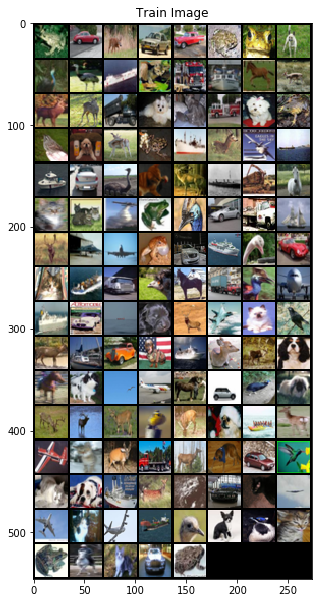

In [8]:
train_iter = iter(train_loader)
images, labels = train_iter.next()

imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [9]:
images.shape


torch.Size([125, 3, 32, 32])

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.BatchNorm2d(32), #filter별로 normalize
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 5 * 5, 100),
            nn.ReLU(),
            nn.Linear(100, 10)              
        )
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*5*5)
        out = self.fc_layer(out)
        
        return out
    
model = CNN().cuda()

In [11]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [12]:
num_epochs = 10

In [13]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/10], lter [200/400], Loss: 1.1961
Epoch [1/10], lter [400/400], Loss: 1.0622
Epoch [2/10], lter [200/400], Loss: 1.1271
Epoch [2/10], lter [400/400], Loss: 0.8792
Epoch [3/10], lter [200/400], Loss: 0.8744
Epoch [3/10], lter [400/400], Loss: 0.8905
Epoch [4/10], lter [200/400], Loss: 0.9029
Epoch [4/10], lter [400/400], Loss: 0.6808
Epoch [5/10], lter [200/400], Loss: 0.8023
Epoch [5/10], lter [400/400], Loss: 0.6178
Epoch [6/10], lter [200/400], Loss: 0.5975
Epoch [6/10], lter [400/400], Loss: 0.6052
Epoch [7/10], lter [200/400], Loss: 0.6106
Epoch [7/10], lter [400/400], Loss: 0.4601
Epoch [8/10], lter [200/400], Loss: 0.4527
Epoch [8/10], lter [400/400], Loss: 0.4944
Epoch [9/10], lter [200/400], Loss: 0.4392
Epoch [9/10], lter [400/400], Loss: 0.6666
Epoch [10/10], lter [200/400], Loss: 0.3817
Epoch [10/10], lter [400/400], Loss: 0.3756


In [14]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 74.970000 %


Predicted:    cat  ship  ship plane  frog


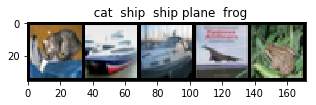

In [15]:
images, labels = iter(test_loader).next()

outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images, normalize=True), title)